In [1]:
import sys
import tensorflow as tf
import torch
import numpy as np
import skimage.io as io
import os

2022-02-25 16:32:09.476840: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
sys.path.append('.')

# Pytorch Dataset wrapper around tfrecords by Huan
### Helper functions

In [3]:
def get_files_ending_with(folder_or_folders, ext):
    if isinstance(folder_or_folders, str):
        folder = folder_or_folders
        assert os.path.exists(folder)

        fnames = []
        for fname in os.listdir(folder):
            if fname.endswith(ext):       
                fnames.append(os.path.join(folder, fname))
        return sorted(fnames)
    else:
        assert hasattr(folder_or_folders, '__iter__')
        print('folder_or_folders:', folder_or_folders)
        return list(itertools.chain(*[get_files_ending_with(folder, ext) for folder in folder_or_folders]))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def collate_batch(batch):
    # image, actions, robot_state, collision_label, info_label, height, width, depth, action_horizon = [], [], [], [], [], [], [], [], []
    # for _image, _actions, _robot_state, _collision_label, _info_label, _height, _width, _depth, _action_horizon in batch:
    #     image.append(_image.numpy())
    #     actions.append(_actions.numpy())
    #     robot_state.append(_robot_state.numpy())
    #     collision_label.append(_collision_label.numpy())
    #     info_label.append(_info_label.numpy())
    #     height.append(_height.numpy())
    #     width.append(_width.numpy())
    #     depth.append(_depth.numpy())
    #     action_horizon.append(_action_horizon.numpy())
    # print('batch[0]:', batch[0])
    image = batch[0][0]
    height = batch[0][1]
    width = batch[0][2]
    depth = batch[0][3]
    
    return torch.Tensor(np.array(image)).to(device), torch.Tensor(np.array(height)).to(device), torch.Tensor(np.array(width)).to(device), torch.Tensor(np.array(depth)).to(device)

/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


### Dataset

In [5]:
class DepthImageDataset(torch.utils.data.IterableDataset):
    def __init__(self, tfrecord_folder):
        super(DepthImageDataset).__init__()
        self.tfrecord_folder = tfrecord_folder
        self.itr = self.load_tfrecords()

    def read_tfrecord(self, serialized_example):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
        }
        example = tf.io.parse_single_example(serialized_example, feature_description)

        image = tf.transpose(tf.cast(tf.io.parse_tensor(example['image'], out_type = tf.uint8), tf.float32),  perm=[2, 0, 1])
        height = example['height']
        width = example['width']
        depth = example['depth']
        return image, height, width, depth

    def load_tfrecords(self, is_shuffle_and_repeat=True, shuffle_buffer_size=5000, prefetch_buffer_size_multiplier=2, batch_size = 32):
        print('Loading tfrecords...')
        tfrecord_fnames = get_files_ending_with(self.tfrecord_folder, '.tfrecords')
        assert len(tfrecord_fnames) > 0
        if is_shuffle_and_repeat:
            np.random.shuffle(tfrecord_fnames)
        else:
            tfrecord_fnames = sorted(tfrecord_fnames)

        dataset = tf.data.TFRecordDataset(tfrecord_fnames)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if is_shuffle_and_repeat: 
            dataset = dataset.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=prefetch_buffer_size_multiplier * batch_size)

        iterator = dataset.__iter__()
        print('Done.')
        return iterator
    
    def __iter__(self):
        return self.itr

### Dataloader

In [6]:
dataset = DepthImageDataset('../../../rl_data/tfrecord')
loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collate_batch)

Loading tfrecords...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Done.


2022-02-25 16:32:11.482467: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-25 16:32:11.483194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-25 16:32:11.484735: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-25 16:32:11.484747: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-02-25 16:32:11.484907: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

In [7]:
data = next(iter(loader))

2022-02-25 16:32:11.550003: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-25 16:32:11.573008: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz


/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


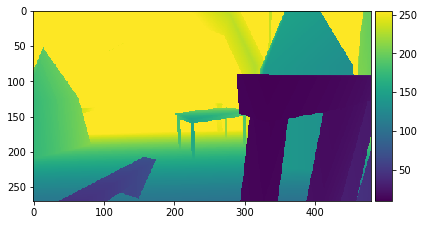

In [8]:
image = data[0]
img_idx = 20
io.imshow(image[img_idx,0,...].numpy())
io.show()

In [9]:
image, height, width, depth = data
image.shape, height.shape, width.shape, depth.shape

(torch.Size([32, 1, 270, 480]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32]))

In [10]:
i = 0
for image, height, width, depth in loader:
    i += 1
    if (i+1) % 50 == 0:
        print(i, ":", image.shape)

49 : <class 'torch.Tensor'>
99 : <class 'torch.Tensor'>
149 : <class 'torch.Tensor'>
199 : <class 'torch.Tensor'>
249 : <class 'torch.Tensor'>
299 : <class 'torch.Tensor'>
349 : <class 'torch.Tensor'>
399 : <class 'torch.Tensor'>
449 : <class 'torch.Tensor'>


KeyboardInterrupt: 